# Data Viz: Assignment 2

In [7]:
import pandas as pd
import numpy as np

pd.set_option('display.precision',2) #decimal pts
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  

### Read in four ATUS microdata files: activity, CPS, repsondent & activity summary

In [8]:
act=pd.read_csv('atusact_2018.dat')
cps=pd.read_csv('atuscps_2018.dat')
resp=pd.read_csv('atusresp_2018.dat')
summ=pd.read_csv('atussum_2018.dat')

### Subset required columns

In [9]:
actCols=['TUCASEID','TEWHERE','TUACTDUR24','TUTIER1CODE','TRTIER2']

In [10]:
act=pd.DataFrame(act, columns=actCols)

In [11]:
cps=cps[cps['TULINENO']==1]

In [12]:
summCols = ['TUCASEID', 'TUFINLWGT','TEAGE','TESEX','TELFS','TRCHILDNUM','TUDIARYDAY','TRHOLIDAY']

In [13]:
summ=pd.DataFrame(summ, columns=summCols)

In [14]:
respCols = ['TUCASEID','TRMJIND1','TRMJOCC1']

In [15]:
resp=pd.DataFrame(resp, columns=respCols)

In [16]:
cpsCols=['TUCASEID','HEFAMINC','PEMARITL']

In [17]:
cps=pd.DataFrame(cps, columns=cpsCols)

### Merge cps, resp & summ data files on TUCASEID

In [18]:
ind=resp.merge(summ, on='TUCASEID')

In [19]:
ind=ind.merge(cps, on='TUCASEID',how='left')

In [20]:
ind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9593 entries, 0 to 9592
Data columns (total 12 columns):
TUCASEID      9593 non-null int64
TRMJIND1      9593 non-null int64
TRMJOCC1      9593 non-null int64
TUFINLWGT     9593 non-null float64
TEAGE         9593 non-null int64
TESEX         9593 non-null int64
TELFS         9593 non-null int64
TRCHILDNUM    9593 non-null int64
TUDIARYDAY    9593 non-null int64
TRHOLIDAY     9593 non-null int64
HEFAMINC      9593 non-null int64
PEMARITL      9593 non-null int64
dtypes: float64(1), int64(11)
memory usage: 974.3 KB


### Make all -1, -2 or -3 values = NaN

In [21]:
act=act.replace([-1,-2,-3],np.NaN)
ind=ind.replace([-1,-2,-3],np.NaN)

## Activity data file

### Divide 'act' into remote (only work away from workplace) & non-remote (only work at workplace) workers

#### Check missings on location (TEWHERE) while working (TRTIER2 = 501)

In [22]:
act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184103 entries, 0 to 184102
Data columns (total 5 columns):
TUCASEID       184103 non-null int64
TEWHERE        148837 non-null float64
TUACTDUR24     184103 non-null int64
TUTIER1CODE    184103 non-null int64
TRTIER2        184103 non-null int64
dtypes: float64(1), int64(4)
memory usage: 7.0 MB


In [23]:
act['TEWHERE'].value_counts()

1.0     79859
12.0    24129
2.0      8374
11.0     6308
13.0     5428
3.0      5326
4.0      3934
7.0      3141
14.0     2393
9.0      2316
6.0      1749
5.0      1711
8.0      1624
31.0      656
89.0      543
15.0      336
16.0      232
30.0      144
32.0      132
17.0      122
10.0      106
19.0       93
20.0       81
21.0       75
18.0       25
Name: TEWHERE, dtype: int64

In [24]:
misloc=act[act['TEWHERE'].isnull()]

In [25]:
misloc['TRTIER2'].value_counts()

101     21402
102     13011
5001      788
104        62
1203        2
1401        1
Name: TRTIER2, dtype: int64

> No code refers to working (501) - These codes in order refer to sleeping, grooming, unable to code, personal activities, relaxing & leisure, and religious & spiritual practices

> Only possible concern is 5001, the cases that are 'unable to code', but given they have not been coded as blank, don't know or refused to answer (-1, -2, -3), they are unlikely to be an issue so analysis continued without excluding them

### Subset act where TRTIER2 = 501 (i.e. all 'working' activities)

In [26]:
working=act[act['TRTIER2']==501]

In [27]:
working.head()

,TUCASEID,TEWHERE,TUACTDUR24,TUTIER1CODE,TRTIER2
179,20180101180165,2.0,120,5,501
181,20180101180165,2.0,120,5,501
183,20180101180165,2.0,120,5,501
185,20180101180165,2.0,150,5,501
211,20180101180507,1.0,325,5,501


#### Make two lists of unique IDs: those who have worked at home, and those who have worked at their workplace

In [28]:
w=working[(working['TEWHERE']==2)]
w=w['TUCASEID'].unique()

In [29]:
h=working[(working['TEWHERE']==1)]
h=h['TUCASEID'].unique()

#### Remote = those only in list 'h'; non-remote = those only in list 'w' (those in both lists have worked both at home and n their workplace)

In [30]:
remoteIds=np.setdiff1d(h,w)

In [31]:
nremoteIds=np.setdiff1d(w,h)

### Subset only remote & non-remote workers & add variable for remote/non-remote 

In [32]:
act=act[(act['TUCASEID'].isin(remoteIds))|(act['TUCASEID'].isin(nremoteIds))]

In [33]:
act['TUCASEID'].nunique()

2843

In [34]:
act['remote']=np.where(act['TUCASEID'].isin(remoteIds), 'Remote','Non-remote')

### Subset specific activities:
* working
* sleeping
* travelling
* eating/drinking
* caring for children (three codes to combine)
* housework
* socialising, relaxation & leisure
* sports, exercise & recreation

In [35]:
tier1codes=[18,12]
tier2codes=[501,101,1101,301,302,303,201,1301]

In [36]:
act=act[(act['TUTIER1CODE'].isin(tier1codes))|(act['TRTIER2'].isin(tier2codes))]

#### Dictionary to create new column of activities

In [37]:
newActs={
    1:'Sleeping',
    2:'Doing housework',
    3:'Childcare',
    5:'Working',
    11:'Eating & Drinking',
    12:'Socialising & relaxing',
    13:'Exercising',
    18:'Travelling'
}

In [38]:
act['newAct']=act['TUTIER1CODE']

In [39]:
act['newAct']=act['newAct'].map(newActs)

In [40]:
act['TUCASEID'].nunique()

2843

### Group data by ID, remote/non-remote & activity, summing up each the time spent doing each activity 

In [41]:
actgrouped=pd.DataFrame(act.groupby(['TUCASEID','remote','newAct'])['TUACTDUR24'].sum().unstack().stack(dropna=False)).reset_index()

In [42]:
actgrouped.rename(columns={ actgrouped.columns[3]: "TUACTDUR24" }, inplace = True)

### Replace missing activity categories with 0 minutes spent doing them (rather than being excluded from empty activities)

In [43]:
#replace NaN with 0 minutes
actgrouped=actgrouped.fillna(0)

In [44]:
actgrouped.head(12)

,TUCASEID,remote,newAct,TUACTDUR24
0,20180101180165,Non-remote,Childcare,117.0
1,20180101180165,Non-remote,Doing housework,30.0
2,20180101180165,Non-remote,Eating & Drinking,120.0
3,20180101180165,Non-remote,Exercising,0.0
4,20180101180165,Non-remote,Sleeping,479.0
5,20180101180165,Non-remote,Socialising & relaxing,30.0
6,20180101180165,Non-remote,Travelling,35.0
7,20180101180165,Non-remote,Working,510.0
8,20180101180507,Remote,Childcare,34.0
9,20180101180507,Remote,Doing housework,0.0


## Merge aggregated activities data with 'ind' data (left join keeping all TUCASEIDs from activity file)

In [45]:
df=actgrouped.merge(ind, on='TUCASEID',how='left')

### Subset data to 'typical worker' (employed & not absent from work last week & age 18 or over)

In [46]:
df=df[(df['TELFS']==1)& (df['TEAGE']>=18)]

### Remove respondents whose diary was on weekend day or a holiday

In [47]:
df=df[((df['TUDIARYDAY']!=1)&(df['TUDIARYDAY']!=7)&(df['TRHOLIDAY']==0))]

In [48]:
df['TUCASEID'].nunique()

1974

## Histograms

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

### Create new separate dataframes of remote & non-remote, subsetting just 'working'

In [51]:
remwork=df[(df['newAct']=='Working')&(df['remote']=='Remote')]

In [52]:
nremwork=df[(df['newAct']=='Working')&(df['remote']=='Non-remote')]

### Create test histogram

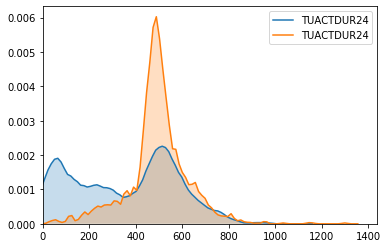

In [53]:
plt.xlim(0,1440)
sns.kdeplot(remwork['TUACTDUR24'],shade=True, kernel='epa')
sns.kdeplot(nremwork['TUACTDUR24'],shade=True, kernel='epa')

## Create datasets to write to csv for each visualisation

### For density plots, get all data but without childcare

In [61]:
density = df[df['newAct']!='Childcare']

In [62]:
density=density[['TUCASEID', 'newAct', 'remote','TUACTDUR24']]

In [63]:
density.head()

,TUCASEID,newAct,remote,TUACTDUR24
1,20180101180165,Doing housework,Non-remote,30.0
2,20180101180165,Eating & Drinking,Non-remote,120.0
3,20180101180165,Exercising,Non-remote,0.0
4,20180101180165,Sleeping,Non-remote,479.0
5,20180101180165,Socialising & relaxing,Non-remote,30.0


In [363]:
density.to_csv("density.csv", index=False)

#### Calculate average time sleeping for remote/non-remote for text div statistic

In [64]:
density[density['newAct'] == 'Sleeping'].groupby('remote').mean()

,TUCASEID,TUACTDUR24
remote,,
Non-remote,2.02e+13,467.29
Remote,2.02e+13,488.90


### For stacked bar, keep all activities and keep sex, age & children columns

In [65]:
bar=df[['TUCASEID','remote','TESEX','TEAGE','TRCHILDNUM','newAct','TUACTDUR24']]

In [66]:
bar.head()

,TUCASEID,remote,TESEX,TEAGE,TRCHILDNUM,newAct,TUACTDUR24
0,20180101180165,Non-remote,2,30,2,Childcare,117.0
1,20180101180165,Non-remote,2,30,2,Doing housework,30.0
2,20180101180165,Non-remote,2,30,2,Eating & Drinking,120.0
3,20180101180165,Non-remote,2,30,2,Exercising,0.0
4,20180101180165,Non-remote,2,30,2,Sleeping,479.0


### Reshape bar chart data using pivot table

In [67]:
bar=bar.pivot_table(index=['TUCASEID', 'remote', 'TESEX', 'TEAGE', 'TRCHILDNUM'], columns='newAct', values='TUACTDUR24').reset_index()

In [68]:
bar.head()

newAct,TUCASEID,remote,TESEX,TEAGE,TRCHILDNUM,Childcare,Doing housework,Eating & Drinking,Exercising,Sleeping,Socialising & relaxing,Travelling,Working
0,20180101180165,Non-remote,2,30,2,117.0,30.0,120.0,0.0,479.0,30.0,35.0,510.0
1,20180101180507,Remote,1,47,1,34.0,0.0,60.0,0.0,525.0,184.0,97.0,505.0
2,20180101180524,Remote,1,37,1,20.0,0.0,20.0,0.0,500.0,200.0,20.0,605.0
3,20180101180542,Remote,1,48,2,300.0,0.0,120.0,0.0,375.0,90.0,130.0,340.0
4,20180101180549,Remote,2,44,2,104.0,174.0,55.0,0.0,540.0,170.0,50.0,185.0


### Create function to assign age bands & create new age band column

In [369]:
def get_ageband(value):
    ageband = None
    if (value >=18) & (value <35):
        ageband = "18 to 34"
    elif (value >34) & (value <54):
        ageband = "35 to 54"
    else:
        ageband = "55+"
    return ageband

In [370]:
bar["ageband"] = bar.TEAGE.apply(get_ageband)

### Add binary column for having/not having children & Add sex column coding 1/2 into male/female

In [371]:
bar['children']= np.where(bar['TRCHILDNUM']==0, 'does not have','has')

In [372]:
bar['sex'] = np.where(bar['TESEX']==2, 'female','male')

### Group by remote/non-remote, age band, sex & children; taking the average time spent on each activity

In [381]:
barAverage = pd.DataFrame(bar.groupby(['remote','ageband','sex','children'])[['Childcare','Eating & Drinking','Exercising','Doing housework','Sleeping','Socialising & relaxing','Travelling','Working']].mean().reset_index())

In [382]:
barAverage

newAct,remote,ageband,sex,children,Childcare,Eating & Drinking,Exercising,Doing housework,Sleeping,Socialising & relaxing,Travelling,Working
0,Non-remote,18 to 34,female,does not have,0.00,61.03,12.85,13.93,486.93,153.92,70.55,485.19
1,Non-remote,18 to 34,female,has,88.28,45.45,5.96,22.75,483.73,111.18,72.62,473.84
2,Non-remote,18 to 34,male,does not have,0.00,56.37,11.28,8.44,480.54,197.83,86.59,483.95
3,Non-remote,18 to 34,male,has,45.64,58.89,8.76,8.46,475.81,151.20,84.70,497.67
4,Non-remote,35 to 54,female,does not have,0.00,62.85,10.40,16.05,466.11,132.69,75.75,507.33
5,Non-remote,35 to 54,female,has,54.49,48.64,6.06,20.04,460.36,120.00,94.67,486.62
6,Non-remote,35 to 54,male,does not have,0.00,62.52,12.17,7.97,486.71,169.73,77.15,519.21
7,Non-remote,35 to 54,male,has,40.39,63.51,17.37,4.23,451.91,140.21,92.49,516.07
8,Non-remote,55+,female,does not have,0.00,58.76,10.05,20.83,458.38,167.68,73.79,482.86
9,Non-remote,55+,female,has,21.10,49.62,5.43,18.19,455.00,168.86,80.14,451.43


In [383]:
barAverage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 12 columns):
remote                    24 non-null object
ageband                   24 non-null object
sex                       24 non-null object
children                  24 non-null object
Childcare                 24 non-null float64
Eating & Drinking         24 non-null float64
Exercising                24 non-null float64
Doing housework           24 non-null float64
Sleeping                  24 non-null float64
Socialising & relaxing    24 non-null float64
Travelling                24 non-null float64
Working                   24 non-null float64
dtypes: float64(8), object(4)
memory usage: 2.4+ KB


In [384]:
barAverage.to_csv('barChartData.csv', index=False)